# Forecast of O3 data: LSTM

## Import required modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from datetime import datetime

2022-05-08 13:13:35.363274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 13:13:35.363317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import data sets

In [3]:
compressed = np.load("O3_model/transformed_datasets.npz",
             allow_pickle = True)

In [4]:
compressed.files

['x_train', 'x_test', 'y_train', 'y_test', 'dt_train', 'dt_test']

In [5]:
# Force arrays into float32 types; otherwise, Keras is unhappy.
ds = {}
for array in ['x_train', 'x_test', 'y_train', 'y_test']:
    ds[array] = compressed[array].astype(np.float32)

## Train & evaluate a simple model

In [6]:
calls = [EarlyStopping(monitor = "val_loss",
                       patience = 3)]

In [7]:
model_monolayer = Sequential()
model_monolayer.add(LSTM(units = 50,
                    activation = "tanh",
                    input_shape = (ds["x_train"].shape[1],
                               ds["x_train"].shape[2])
                    ))
model_monolayer.add(Dense(1))
model_monolayer.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

2022-05-08 13:13:42.334352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 13:13:42.334463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 13:13:42.334518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dwarven-notebook): /proc/driver/nvidia/version does not exist
2022-05-08 13:13:42.335342: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


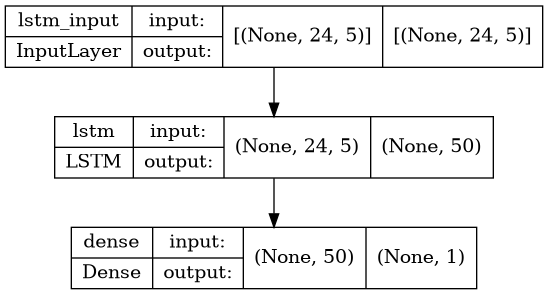

In [8]:
plot_model(model_monolayer,
           show_shapes = True,
           expand_nested = True)

In [9]:
history_monolayer = model_monolayer.fit(ds["x_train"],
                              ds["y_train"],
                              epochs = 20,
                              batch_size = 32,
                              verbose = 1,
                              validation_data = (ds["x_test"], ds["y_test"]),
                              shuffle = False,
                              callbacks = calls)

Epoch 1/20
3683/3683 [==============================] - 62s 16ms/step - loss: 127.7723 - mse: 127.7723 - mae: 7.1197 - val_loss: 40.7604 - val_mse: 40.7604 - val_mae: 4.2732
Epoch 2/20
3683/3683 [==============================] - 57s 15ms/step - loss: 36.1621 - mse: 36.1621 - mae: 3.8358 - val_loss: 30.1025 - val_mse: 30.1025 - val_mae: 3.7100
Epoch 3/20
3683/3683 [==============================] - 57s 16ms/step - loss: 31.5613 - mse: 31.5613 - mae: 3.6213 - val_loss: 27.4320 - val_mse: 27.4320 - val_mae: 3.6518
Epoch 4/20
3683/3683 [==============================] - 58s 16ms/step - loss: 29.9009 - mse: 29.9009 - mae: 3.5302 - val_loss: 26.0300 - val_mse: 26.0300 - val_mae: 3.4879
Epoch 5/20
3683/3683 [==============================] - 58s 16ms/step - loss: 28.5113 - mse: 28.5113 - mae: 3.4418 - val_loss: 25.3572 - val_mse: 25.3572 - val_mae: 3.4128
Epoch 6/20
3683/3683 [==============================] - 56s 15ms/step - loss: 27.7166 - mse: 27.7166 - mae: 3.3898 - val_loss: 25.5428 - v

In [10]:
model_monolayer.save("O3_model/model_monolayer")

2022-05-08 13:34:11.597981: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: O3_model/model_monolayer/assets


INFO:tensorflow:Assets written to: O3_model/model_monolayer/assets


In [11]:
history_mono_df = pd.DataFrame(history_monolayer.history)

<AxesSubplot:>

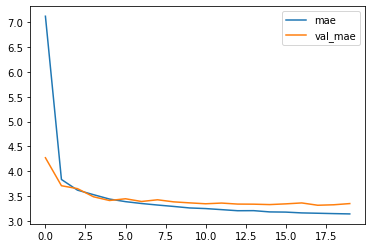

In [12]:
history_mono_df.plot(kind = "line", y = ["mae", "val_mae"])

In [13]:
preds_mono = pd.DataFrame(model_monolayer.predict(ds["x_test"]), columns = ["predicted_O3"])

In [14]:
preds_mono["measured_O3"] = ds["y_test"]
preds_mono["DateTime"] = compressed["dt_test"]

In [15]:
preds_mono.head()

,predicted_O3,measured_O3,DateTime
0,33.958549,38.0,2015-05-26 01:00:00
1,35.958752,37.0,2015-05-26 02:00:00
2,35.132427,39.0,2015-05-26 03:00:00
3,36.200432,33.0,2015-05-26 04:00:00
4,29.710758,30.0,2015-05-26 05:00:00


<AxesSubplot:xlabel='DateTime'>

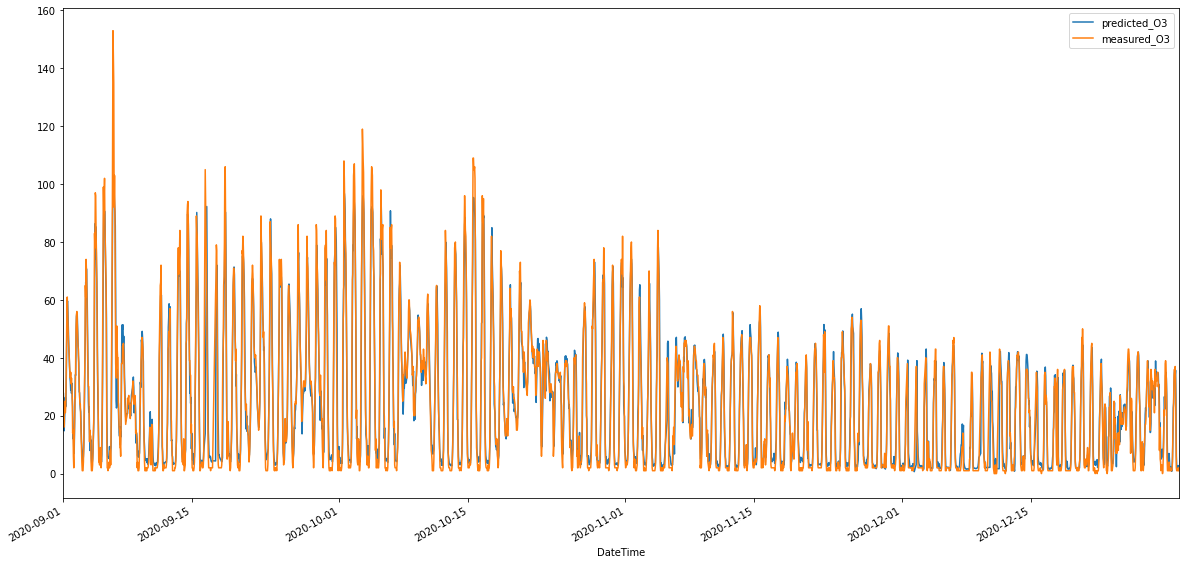

In [16]:
preds_mono.plot(kind = "line",
                y = ["predicted_O3", "measured_O3"],
                x = "DateTime",
                figsize = (20, 10),
                xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
                subplots = False)

## Evaluate the impact of adding a second LSTM layer.
As a control, keep the total number of neurons constant vs. the first model (50).

In [19]:
model_bilayer = Sequential()
model_bilayer.add(LSTM(units = 25,
                  activation = "tanh",
                  input_shape = (ds["x_train"].shape[1],
                                 ds["x_train"].shape[2]),
                  return_sequences = True
                  ))
model_bilayer.add(LSTM(units = 25,
                    activation = "tanh"))
model_bilayer.add(Dense(1))
model_bilayer.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

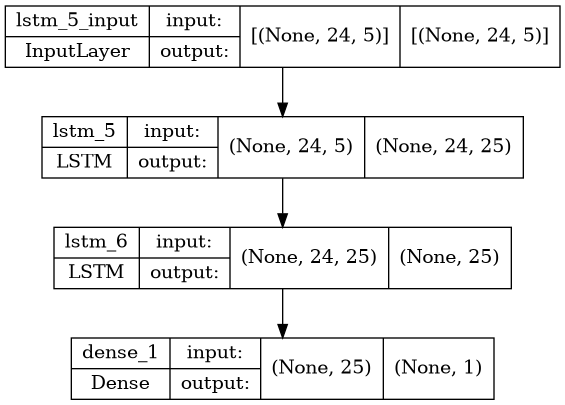

In [20]:
plot_model(model_bilayer,
           show_shapes = True,
           expand_nested = True)

In [21]:
history_bilayer = model_bilayer.fit(ds["x_train"],
                              ds["y_train"],
                              epochs = 20,
                              batch_size = 32,
                              verbose = 1,
                              validation_data = (ds["x_test"], ds["y_test"]),
                              shuffle = False,
                              callbacks = calls)

Epoch 1/20
3683/3683 [==============================] - 107s 28ms/step - loss: 169.9301 - mse: 169.9301 - mae: 8.1477 - val_loss: 55.3545 - val_mse: 55.3545 - val_mae: 4.8550
Epoch 2/20
3683/3683 [==============================] - 102s 28ms/step - loss: 42.9826 - mse: 42.9826 - mae: 4.0571 - val_loss: 35.5105 - val_mse: 35.5105 - val_mae: 4.2150
Epoch 3/20
3683/3683 [==============================] - 96s 26ms/step - loss: 33.8414 - mse: 33.8414 - mae: 3.6993 - val_loss: 28.5418 - val_mse: 28.5418 - val_mae: 3.7192
Epoch 4/20
3683/3683 [==============================] - 95s 26ms/step - loss: 31.5091 - mse: 31.5091 - mae: 3.5930 - val_loss: 27.7221 - val_mse: 27.7221 - val_mae: 3.6733
Epoch 5/20
3683/3683 [==============================] - 87s 24ms/step - loss: 30.3651 - mse: 30.3651 - mae: 3.5358 - val_loss: 26.6248 - val_mse: 26.6248 - val_mae: 3.5974
Epoch 6/20
3683/3683 [==============================] - 86s 23ms/step - loss: 29.4647 - mse: 29.4647 - mae: 3.4803 - val_loss: 26.1640 -

In [32]:
model_bilayer.save("O3_model/model_bilayer")

INFO:tensorflow:Assets written to: O3_model/model_bilayer/assets


INFO:tensorflow:Assets written to: O3_model/model_bilayer/assets


In [22]:
history_bi_df = pd.DataFrame(history_bilayer.history)

<AxesSubplot:>

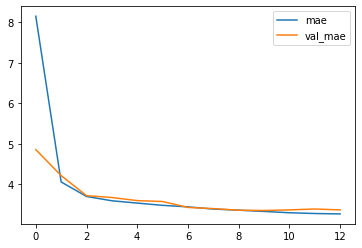

In [23]:
history_bi_df.plot(kind = "line", y = ["mae", "val_mae"])

In [24]:
preds_bi = pd.DataFrame(model_bilayer.predict(ds["x_test"]), columns = ["predicted_O3"])

In [25]:
preds_bi["measured_O3"] = ds["y_test"]
preds_bi["DateTime"] = compressed["dt_test"]

In [26]:
preds_bi.head()

,predicted_O3,measured_O3,DateTime
0,34.327320,38.0,2015-05-26 01:00:00
1,37.047092,37.0,2015-05-26 02:00:00
2,35.662075,39.0,2015-05-26 03:00:00
3,37.322216,33.0,2015-05-26 04:00:00
4,30.057556,30.0,2015-05-26 05:00:00


<AxesSubplot:xlabel='DateTime'>

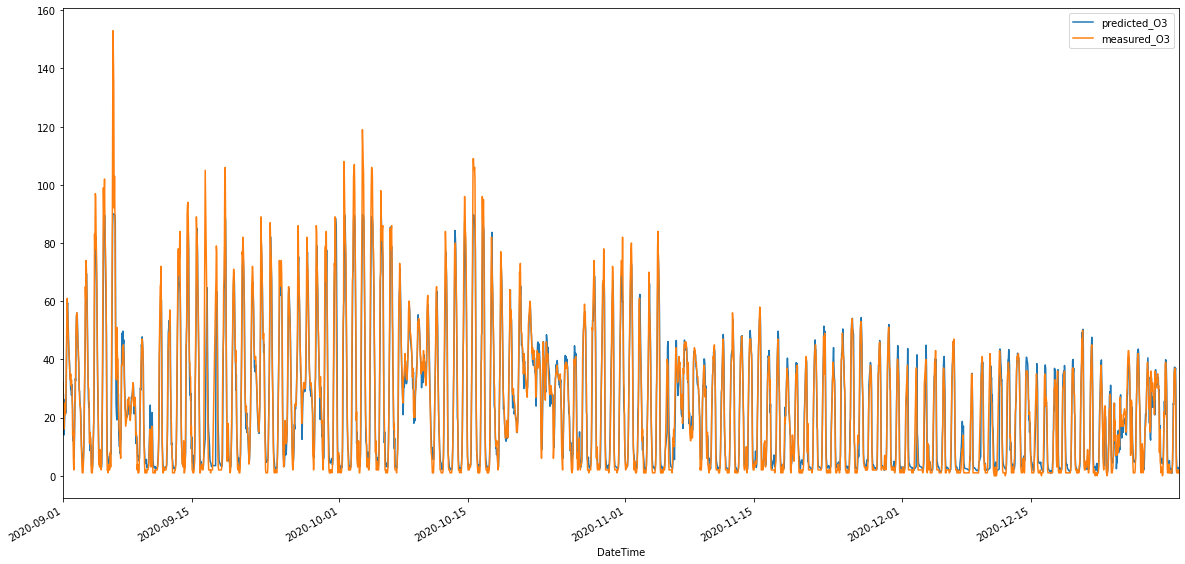

In [28]:
preds_bi.plot(kind = "line",
                y = ["predicted_O3", "measured_O3"],
                x = "DateTime",
                figsize = (20, 10),
                xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
                subplots = False)

## Compare the two models

In [29]:
# Combine predictions from both models into a single dataframe
preds = preds_bi[["DateTime", "measured_O3"]]
preds["pred_O3_bilayer"] = preds_bi["predicted_O3"]
preds["pred_O3_monolayer"] = preds_mono["predicted_O3"]

In [30]:
# Calculate absolute error for reach model & timepoint
preds["mono_abs_err"] = abs(preds["pred_O3_monolayer"] - preds["measured_O3"])
preds["bi_abs_err"] = abs(preds["pred_O3_bilayer"] - preds["measured_O3"])
preds.head()

,DateTime,measured_O3,pred_O3_bilayer,pred_O3_monolayer,mono_abs_err,bi_abs_err
0,2015-05-26 01:00:00,38.0,34.327320,33.958549,4.041451,3.672680
1,2015-05-26 02:00:00,37.0,37.047092,35.958752,1.041248,0.047092
2,2015-05-26 03:00:00,39.0,35.662075,35.132427,3.867573,3.337925
3,2015-05-26 04:00:00,33.0,37.322216,36.200432,3.200432,4.322216
4,2015-05-26 05:00:00,30.0,30.057556,29.710758,0.289242,0.057556


In [31]:
# Calculate MAE
preds[["mono_abs_err", "bi_abs_err"]].mean()

mono_abs_err    3.351050
bi_abs_err      3.367327
dtype: float32

The monolayered model gives marginally better performance on average, and it trained in roughly half the time. This model should be used as the starting point for future refinement.